# 状態空間モデル

[こちら](https://qiita.com/ryouta0506/items/161e07c2cd041191d3cc)を参考に、状態空間モデルを少しいじってみる


# データの読み込み

In [138]:
import pandas as pd

# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data_2016 = pd.read_csv('./data/juyo-2016.csv', header=1, encoding="SHIFT-JIS")
print(len(data_2016))
data_2016.head()

6600


,DATE,TIME,実績(万kW)
0,2016/4/1,0:00,2555
1,2016/4/1,1:00,2433
2,2016/4/1,2:00,2393
3,2016/4/1,3:00,2375
4,2016/4/1,4:00,2390


In [139]:
data_2017 = pd.read_csv('./data/juyo-2017.csv', header=1, encoding="SHIFT-JIS")
data_2018 = pd.read_csv('./data/juyo-2018.csv', header=1, encoding="SHIFT-JIS")
# data_2019 = pd.read_csv('./data/juyo-2019.csv', header=1, encoding="SHIFT-JIS")
print(len(data_2017))
print(len(data_2018))
# print(len(data_2019))

# data_2019.head()

8760
8760


In [204]:
# 2016~2019年分のデータを結合してひとまとめのデータにする。

data = pd.concat([data_2016 
                  ,data_2017
                  ,data_2018
                  # ,data_2019
                 ])
print(len(data))
data.tail()

24120


,DATE,TIME,実績(万kW)
8755,2018/12/31,19:00,3531
8756,2018/12/31,20:00,3473
8757,2018/12/31,21:00,3376
8758,2018/12/31,22:00,3252
8759,2018/12/31,23:00,3198


In [205]:
# 日付と時刻を結合してインデックスにする
data['datetime_'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])
data = data.set_index('datetime_')
data = data.drop(['DATE','TIME'], axis=1)
data = data.rename(columns={'実績(万kW)': '10k_kw'})
data.head()

,10k_kw
datetime_,
2016-04-01 00:00:00,2555
2016-04-01 01:00:00,2433
2016-04-01 02:00:00,2393
2016-04-01 03:00:00,2375
2016-04-01 04:00:00,2390


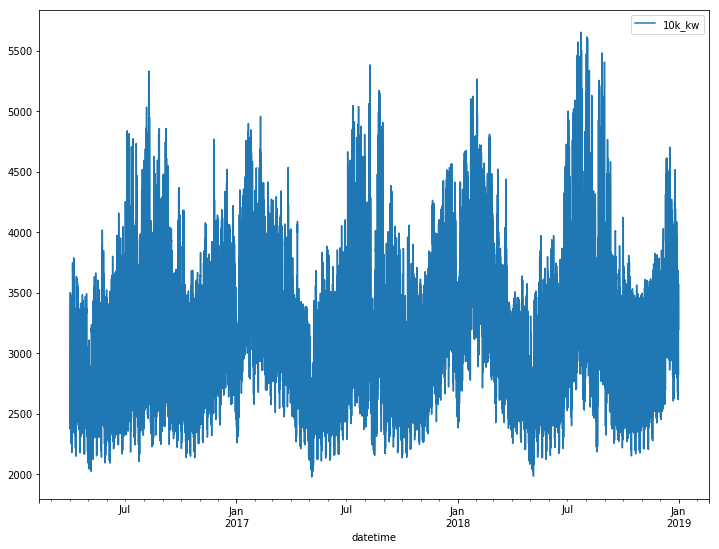

In [142]:
# 可視化
%matplotlib inline

data.plot(figsize=(12, 9))

# 季節性・トレンド等を可視化

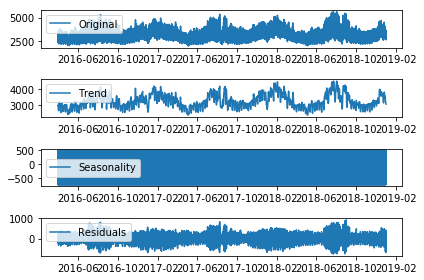

In [143]:
# 傾向(trend)、季節性(seasonal)、残差(residual)に分解してモデル化する。
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# オリジナルの時系列データプロット
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

# trend のプロット
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# seasonal のプロット
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

# residual のプロット
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 自己相関を確認

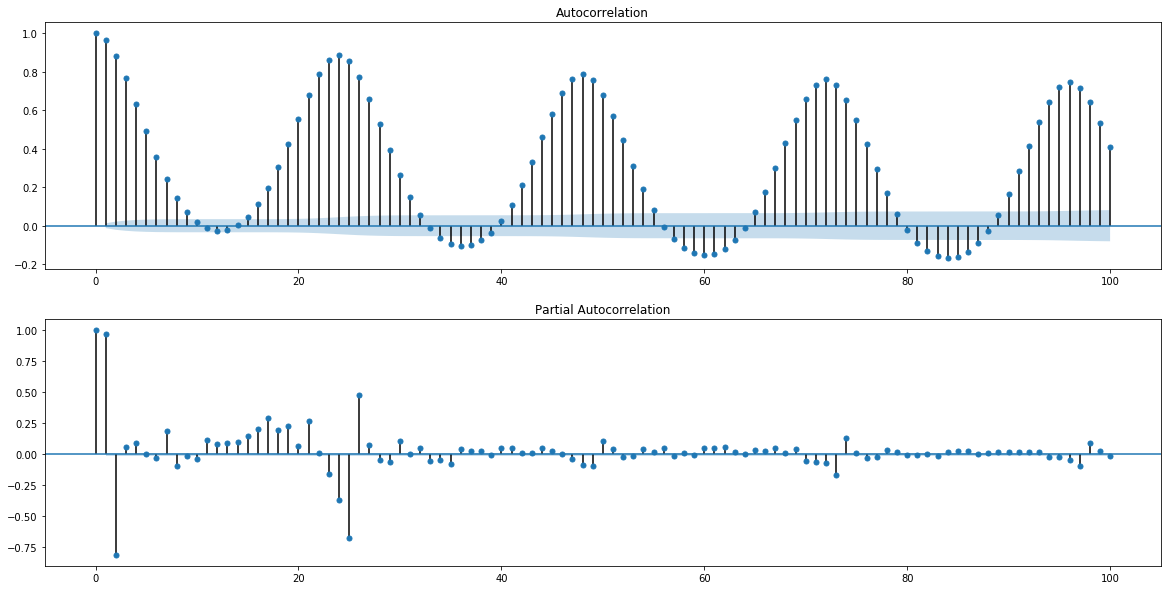

In [144]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_acf(data['10k_kw'], lags=100, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data['10k_kw'], lags=100, ax=ax2)

自己相関の確認から、下記のことがわかった。

- 近い時間帯と相関がある。  
- 前日の同一時間帯とも相関がある。  
- 二日以上前となると、あまり相関がない。  

In [145]:
# 定常過程かどうかを確認するために、単位根検定をする。（ADF検定）

from statsmodels.tsa import stattools
res_ctt = stattools.adfuller(x=data['10k_kw'], 
                             regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = stattools.adfuller(x=data['10k_kw'], 
                            regression="ct") # トレンド項あり（１次）、定数項あり
res_c = stattools.adfuller(x=data['10k_kw'], 
                           regression="c") # トレンド項なし、定数項あり
res_nc = stattools.adfuller(x=data['10k_kw'], 
                            regression="nc") # トレンド項なし、定数項なし
print('====res-ctt====')
print('adf_test_static:{}'.format(res_ctt[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_ctt[1]))
print('usedlag:{}'.format(res_ctt[2]))
print('nobs:{}'.format(res_ctt[3]))
print('critical values:{}'.format(res_ctt[4])) # 棄却点
print('icbest:{}'.format(res_ctt[5])) # maximized information criterion

print('====res-ct====')
print('adf_test_static:{}'.format(res_ct[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_ct[1]))
print('usedlag:{}'.format(res_ct[2]))
print('nobs:{}'.format(res_ct[3]))
print('critical values:{}'.format(res_ct[4])) # 棄却点
print('icbest:{}'.format(res_ct[5])) # maximized information criterion

print('====res-c====')
print('adf_test_static:{}'.format(res_c[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_c[1]))
print('usedlag:{}'.format(res_c[2]))
print('nobs:{}'.format(res_c[3]))
print('critical values:{}'.format(res_c[4])) # 棄却点
print('icbest:{}'.format(res_c[5])) # maximized information criterion

print('====res-nc====')
print('adf_test_static:{}'.format(res_nc[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_nc[1]))
print('usedlag:{}'.format(res_nc[2]))
print('nobs:{}'.format(res_nc[3]))
print('critical values:{}'.format(res_nc[4])) # 棄却点
print('icbest:{}'.format(res_nc[5])) # maximized information criterion

====res-ctt====
adf_test_static:-11.837287479998283
pvalue:4.0100025382921957e-19
usedlag:48
nobs:24071
critical values:{'1%': -4.371611479316717, '5%': -3.8326353665857584, '10%': -3.553412042707027}
icbest:252839.9145917772
====res-ct====
adf_test_static:-11.72763275905749
pvalue:1.0865178439735506e-18
usedlag:48
nobs:24071
critical values:{'1%': -3.9591461489442783, '5%': -3.410672409350163, '10%': -3.1271574223379965}
icbest:252840.4964568033
====res-c====
adf_test_static:-11.609846999015229
pvalue:2.5286086786993212e-21
usedlag:48
nobs:24071
critical values:{'1%': -3.4306216961277367, '5%': -2.86166008125817, '10%': -2.5668339157781745}
icbest:252841.25297582458
====res-nc====
adf_test_static:-1.3339690141257083
pvalue:0.16878917609281957
usedlag:48
nobs:24071
critical values:{'1%': -2.565832889812606, '5%': -1.9410111644610064, '10%': -1.6168089706578872}
icbest:252972.16304627882


ADF検定の結果、トレンド項があれば「非定常である」という帰無仮説を棄却できることがわかった。  
また、可視化結果から電力需要に季節性があることが明らかなので、今回は「SARIMA」を使ってみる。  

In [147]:
# 自動ARMA推定関数の実行
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html
# https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#arma_order_select_ic
res = sm.tsa.arma_order_select_ic(data, # data
                                      ic='aic', # 評価基準。BIC等も指定可能
                                      trend='c' # トレンドの有無
                                     )
res

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: N

{'aic':                0              1              2
 0  380846.073235  350199.821812  329582.638358
 1  314516.773005  299202.260189  293382.560298
 2  289157.697163  289094.235501  288867.879608
 3  289079.780411  287819.331446  288866.665444
 4  288894.004940  288895.411824  286389.517929, 'aic_min_order': (4, 2)}

以上から、ARMAの次数は(4,2)とする。  
続いて、季節性についてはコレログラムの結果から24（日単位）としてみる。

In [148]:
# 季節性を日単位周期と仮定した際の、SARIMA
import matplotlib.pyplot as plt
%matplotlib inline

model = sm.tsa.SARIMAX(data,
                       order=(4,0,2),
                       seasonal_order=(4,0,2,24) # ここの次数はARMAとは異なる。色々入れて結果を確認して調整していく泥臭い感じかな...。とりあえず最初は(1,1,1)から始める。
                        )
result_sarima = model.fit()
fig = plt.figure(figsize=(20,5))
plt.plot(result_sarima.predict(start='2018-12-01 00:00:00',end='2019-02-01 00:00:00'),label='predict')
plt.plot(data['10k_kw'],label='true')
plt.xlim('2018-10-01 00:00:00', '2019-02-01 00:00:00')
plt.legend()
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

時間単位でやると、計算に時間がかかりまくる。(10分経っても返ってこない)  
参考にしたエントリーをよく見ると、週単位でデータをまとめているみたい。  
なので、こちらも一回勉強用ということで、データを週単位でまとめて、季節性を見てみようと思う。  

In [219]:
# データを週単位で合計する
import numpy as np

df_weekly=data.groupby(pd.TimeGrouper(freq='W')).aggregate(np.sum)[1:] 
df_weekly

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


,10k_kw
datetime_,
2016-04-10,491388
2016-04-17,493786
2016-04-24,481093
2016-05-01,470489
2016-05-08,431540
2016-05-15,489564
2016-05-22,487724
2016-05-29,504091
2016-06-05,477184


# トレンド等を可視化

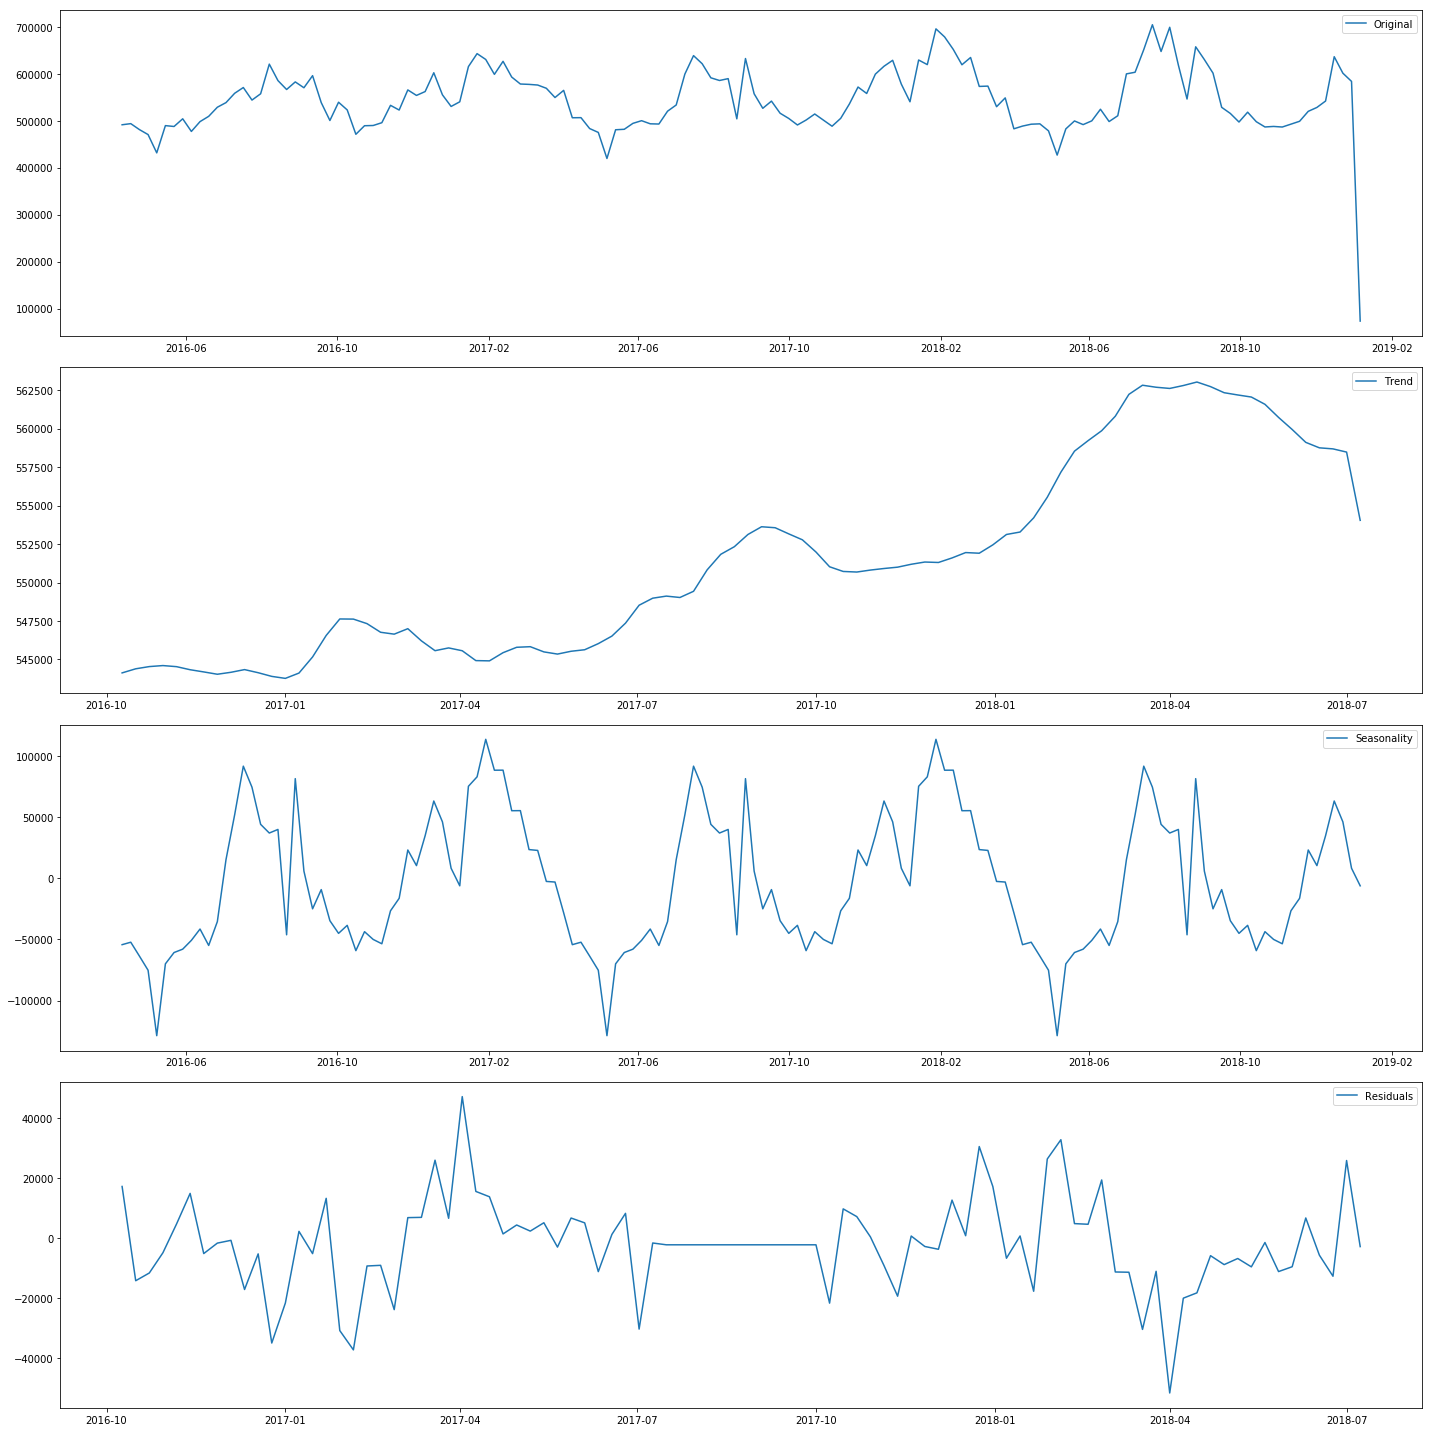

In [220]:
# 傾向(trend)、季節性(seasonal)、残差(residual)に分解してモデル化する。
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_weekly)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,20))

# オリジナルの時系列データプロット
plt.subplot(411)
plt.plot(df_weekly, label='Original')
plt.legend(loc='best')

# trend のプロット
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# seasonal のプロット
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

# residual のプロット
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 自己相関を確認

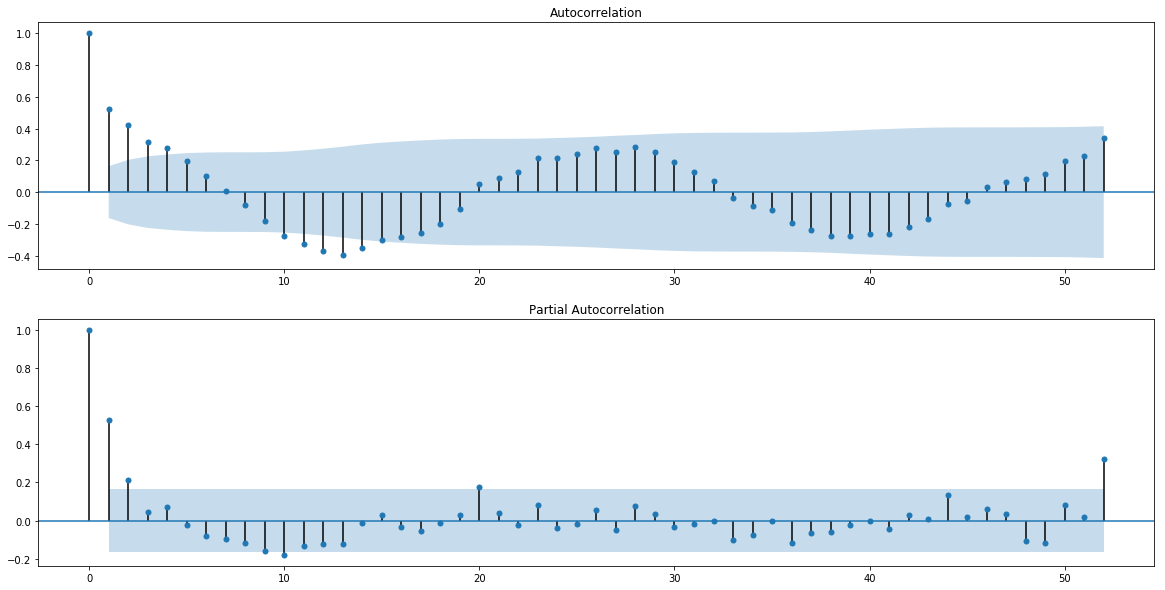

In [221]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_acf(df_weekly['10k_kw'], lags=52, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(df_weekly['10k_kw'], lags=52, ax=ax2)

# 自己相関の確認結果
- 自己相関を見ると、26週間（半年）単位で季節性がありそう  
- 偏自己相関を見ると、直近のデータだけが関係ありそう

# 単位根検定

In [224]:
from statsmodels.tsa import stattools
res_ctt = stattools.adfuller(x=df_weekly['10k_kw'], 
                             regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = stattools.adfuller(x=df_weekly['10k_kw'], 
                            regression="ct") # トレンド項あり（１次）、定数項あり
res_c = stattools.adfuller(x=df_weekly['10k_kw'], 
                           regression="c") # トレンド項なし、定数項あり
res_nc = stattools.adfuller(x=df_weekly['10k_kw'], 
                            regression="nc") # トレンド項なし、定数項なし

print('====res-ctt====')
print('adf_test_static:{}'.format(res_ctt[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_ctt[1]))
print('usedlag:{}'.format(res_ctt[2]))
print('nobs:{}'.format(res_ctt[3]))
print('critical values:{}'.format(res_ctt[4])) # 棄却点
print('icbest:{}'.format(res_ctt[5])) # maximized information criterion

print('====res-ct====')
print('adf_test_static:{}'.format(res_ct[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_ct[1]))
print('usedlag:{}'.format(res_ct[2]))
print('nobs:{}'.format(res_ct[3]))
print('critical values:{}'.format(res_ct[4])) # 棄却点
print('icbest:{}'.format(res_ct[5])) # maximized information criterion

print('====res-c====')
print('adf_test_static:{}'.format(res_c[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_c[1]))
print('usedlag:{}'.format(res_c[2]))
print('nobs:{}'.format(res_c[3]))
print('critical values:{}'.format(res_c[4])) # 棄却点
print('icbest:{}'.format(res_c[5])) # maximized information criterion

print('====res-nc====')
print('adf_test_static:{}'.format(res_nc[0])) # 絶対値が棄却点より大きければ、帰無仮説を棄却できる。
print('pvalue:{}'.format(res_nc[1]))
print('usedlag:{}'.format(res_nc[2]))
print('nobs:{}'.format(res_nc[3]))
print('critical values:{}'.format(res_nc[4])) # 棄却点
print('icbest:{}'.format(res_nc[5])) # maximized information criterion

====res-ctt====
adf_test_static:-3.1864306721715474
pvalue:0.21439277213790386
usedlag:0
nobs:143
critical values:{'1%': -4.454032224705706, '5%': -3.8743398391529738, '10%': -3.5791321829200187}
icbest:3196.43125449522
====res-ct====
adf_test_static:-2.8934823670691623
pvalue:0.16433198185600456
usedlag:0
nobs:143
critical values:{'1%': -4.023514459232879, '5%': -3.441649494385999, '10%': -3.145330713164287}
icbest:3197.2778921206987
====res-c====
adf_test_static:-3.0843982568262347
pvalue:0.0277295397676719
usedlag:0
nobs:143
critical values:{'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}
icbest:3196.6055393926554
====res-nc====
adf_test_static:-0.9327436286401593
pvalue:0.3153748310914106
usedlag:0
nobs:143
critical values:{'1%': -2.581552333121424, '5%': -1.943032199977635, '10%': -1.6150867039645278}
icbest:3202.4362731583055


# 単位根検定結果

トレンドに定数項を過程すれば、定常過程だとして作業を進められそう。

# ARMAの次数決定

In [223]:
res = sm.tsa.arma_order_select_ic(df_weekly, # data
                                      ic='aic', # 評価基準。BIC等も指定可能
                                      trend='c' # トレンドの有無
                                     )
res

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'aic':              0            1            2
 0  3628.033030  3585.719450  3566.288283
 1  3557.753365  3559.941482  3560.320351
 2  3559.901664  3560.634448  3562.017118
 3  3560.391867  3562.166629  3558.943979
 4  3562.115654  3564.112746  3560.927806, 'aic_min_order': (1, 0)}

# ARMAの次数について

p=１,q=0を使う。

# モデルの学習

ARIMAの次数は(1,0,0)。  
季節性については、半年単位の周期（26）があるとしてモデルの同定を進める。

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


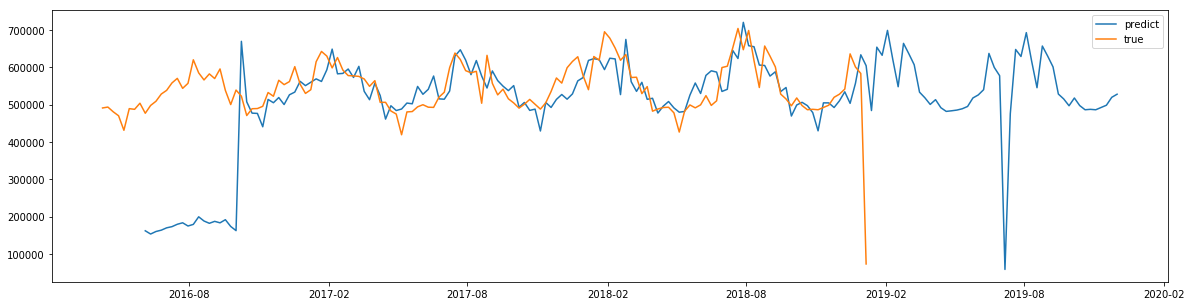

In [230]:
# 季節性を半年単位周期と仮定した際の、SARIMA
import matplotlib.pyplot as plt
%matplotlib inline

model = sm.tsa.SARIMAX(df_weekly,
                       order=(1,0,0),
                       seasonal_order=(1,1,1,26)
                       # enforce_stationarity=False,
                       # enforce_invertibility=False
                        )
result_sarima = model.fit()
fig = plt.figure(figsize=(20,5))
plt.plot(result_sarima.predict(start='2016-06',end='2019-12'),label='predict')
plt.plot(df_weekly['10k_kw'],label='true')
plt.legend()
plt.show()

In [231]:
# パラメータのチェック
print(result_sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             10k_kw   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 26)   Log Likelihood               -1479.778
Date:                            Sat, 05 Jan 2019   AIC                           2967.556
Time:                                    06:39:24   BIC                           2978.638
Sample:                                04-10-2016   HQIC                          2972.056
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3218      0.057      5.627      0.000       0.210       0.434
ar.S.L26      -0.9772      0.063   

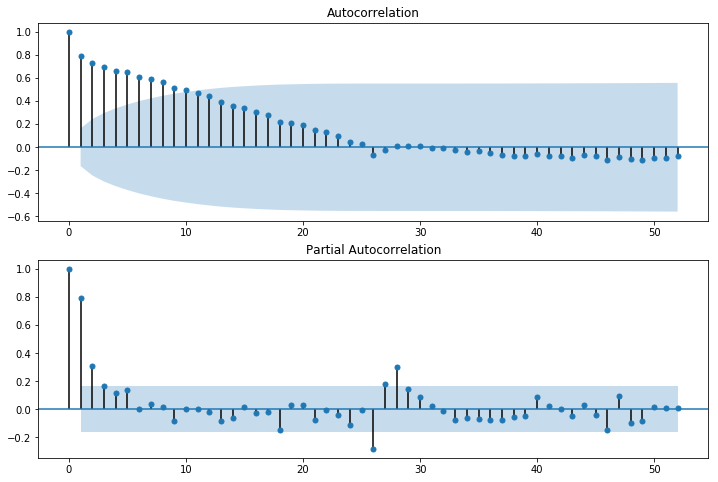

In [232]:
# 残差のチェック
# 残渣に自己相関が残っていないことを確認する。
residSARIMA = result_sarima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=52, ax=ax2)


# まだ残渣に自己相関が残っている。もう少しモデルのパラメータを調整してみる

In [233]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
# Gridsearch形式
'''
ARIMA(p, d, q)
季節(sp, sd, sq)
pは自己回帰モデルの次数：AR(p)、
qは移動平均モデルの次数：MA(q)、
dは差分をとる回数：I(d)
です。
'''

max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern # 計算するパターン数

192

In [234]:
# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX( # https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
                            df_weekly, order=(p,d,q),
                            seasonal_order=(sp,sd,sq,26),
                            enforce_stationarity = False,
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.ix[num]["aic"] = sarima.aic
                        num = num + 1

# AIC最小モデル
modelSelection[modelSelection.aic == min(modelSelection.aic)]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceW

,model,aic
127,"order=(2,1,3), season=(1,1,1)",2174.79


# 上記で求めた次数でモデルを作り直す

In [236]:
#　AICが最小の次数でモデルを学習し直す
bestSARIMA = sm.tsa.SARIMAX(df_weekly
                            ,order=(2,1,3)
                            ,seasonal_order=(1,1,1,26)
                            ,enforce_stationarity = False 
                            ,enforce_invertibility = False
                           ).fit()

print(bestSARIMA.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             10k_kw   No. Observations:                  144
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 26)   Log Likelihood               -1079.394
Date:                            Sat, 05 Jan 2019   AIC                           2174.787
Time:                                    06:45:29   BIC                           2194.515
Sample:                                04-10-2016   HQIC                          2182.731
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5190      0.180     -2.879      0.004      -0.872      -0.166
ar.L2         -0.7197      0.164   

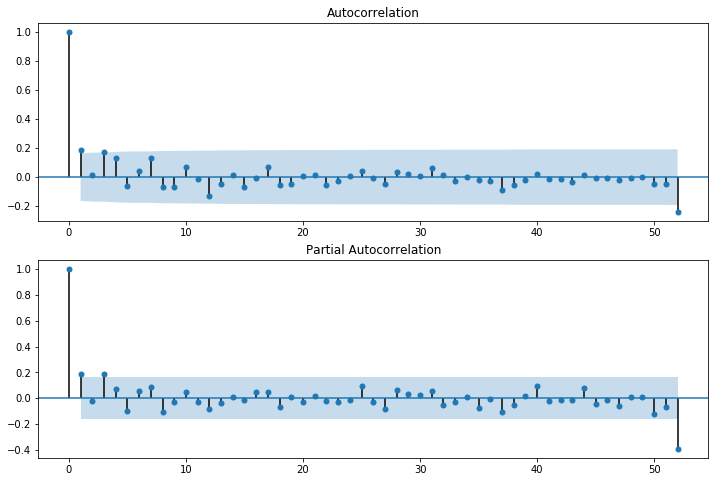

In [237]:
# 残差のチェック
residSARIMA = bestSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=52, ax=ax2)

# 予測結果を可視化してみる

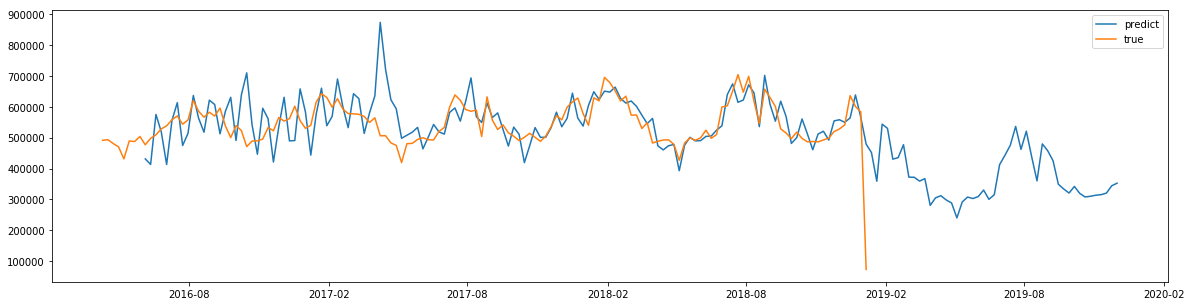

In [238]:
fig = plt.figure(figsize=(20,5))
plt.plot(bestSARIMA.predict(start='2016-06',end='2019-12'),label='predict')
plt.plot(df_weekly['10k_kw'],label='true')
plt.legend()
plt.show()

In [260]:
# 実際の値と予測値における、MSEを求める(おまけ)

from statsmodels.tools.eval_measures import mse

start = '2018-03-11'
end = '2019-01-06'

predicted = bestSARIMA.predict(start=start,end=end)
origin = df_weekly['10k_kw'][start:end]
# 普通のMSE
print(mse(origin, predicted, axis=0))

5125320036.873208
